In [1]:
%%capture
%cd ..

In [2]:
from src.model.esn import ESN
from src.model.lstm import LSTM
from src.trainer.ridge_regression_trainer import RidgeRegressionTrainer
from src.trainer.bptt_trainer import BPTTTrainer
from src.dataset import create_sifim_datasets
from src.trainer.model_selection import retraining
import torch
import matplotlib.pyplot as plt

In [3]:
batch_size=16
shuffle=True

tr_dataset, vl_dataset, ts_dataset = create_sifim_datasets(vl_perc=0.2, ts_perc=0.2, noise=0.005)

In [4]:
def format_result(result):
    return dict(mse=result[0], time=result[1], emissions=result[2], **result[3])

In [5]:
lstm_results = []


def store_lstm_accuracy(trainer):
    lstm_results.append(format_result(trainer.test()))

retraining(
    model_constructor=LSTM,
    trainer_constructor=lambda *args, **kwargs: BPTTTrainer(*args, callback=store_lstm_accuracy, **kwargs),
    tr_dataset=tr_dataset,
    ts_dataset=ts_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    hyperparams_path=f'hyperparams/LSTM_hyperparams.json',
    model_path=None,  #f'models/LSTM.torch',
    history_path=None, #'history/history.json',
)

2023-12-15 13:35:23,908 - root - INFO - LSTM results => training loss: 4.311533096894498e-06, test loss: 1.7466640614640906e-05, tr_time: 116.70900774002075, tr_emissions: 0.0001215270035352552, ts_time: 1.5158321857452393, ts_emissions: 0.00012339394325233338, scores: {'accuracy': 0.8212783014807162, 'precision': 0.9384791854187047, 'recall': 0.7132199839302111, 'f1_score': 0.8104643266751669}


LSTM(
  (lstm): LSTM(88, 200, batch_first=True)
  (ff): Linear(in_features=200, out_features=88, bias=True)
)

In [6]:
esn_results = format_result(RidgeRegressionTrainer(
    torch.load('models/ESN.torch'),
    torch.utils.data.DataLoader(tr_dataset, batch_size=batch_size, shuffle=shuffle),
    torch.utils.data.DataLoader(ts_dataset, batch_size=batch_size, shuffle=shuffle),
).test())

In [7]:
def plot(key):
    plt.figure(figsize=(12, 7))
    plt.title(key)
    plt.plot([r[key] for r in lstm_results], label='LSTM')
    plt.plot([esn_results[key] for _ in lstm_results], linestyle='--', label='ESN')
    plt.xlabel('epochs')
    plt.ylabel(key)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'plots/development_{key}')
    plt.show()

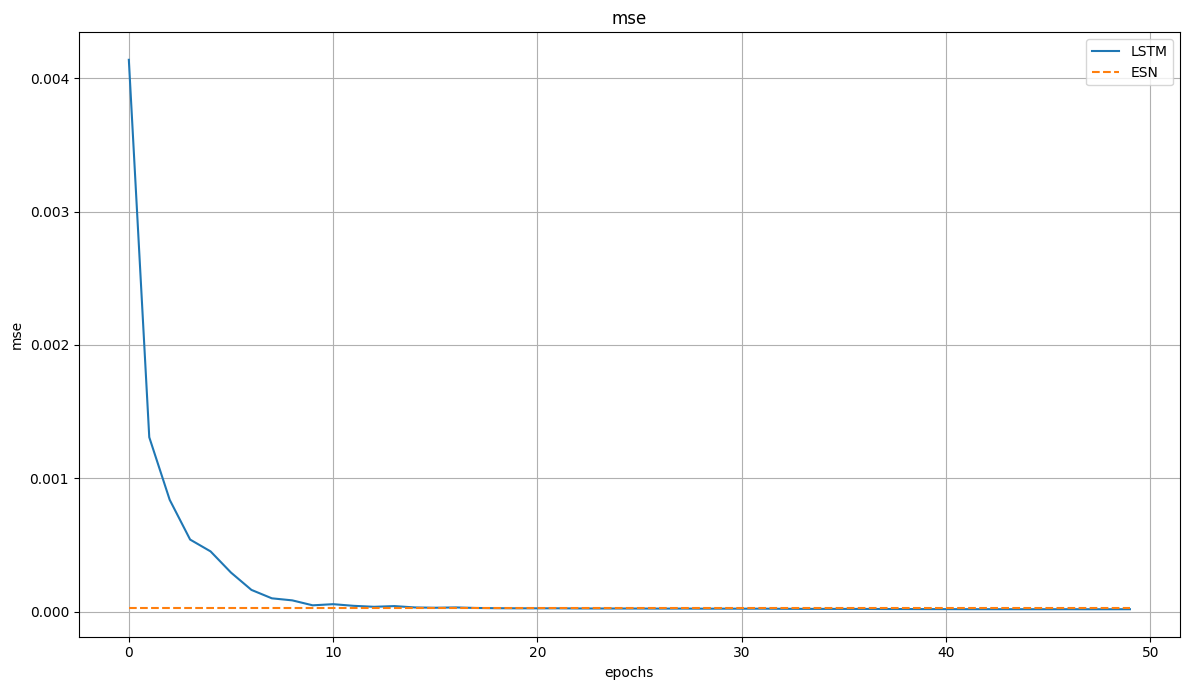

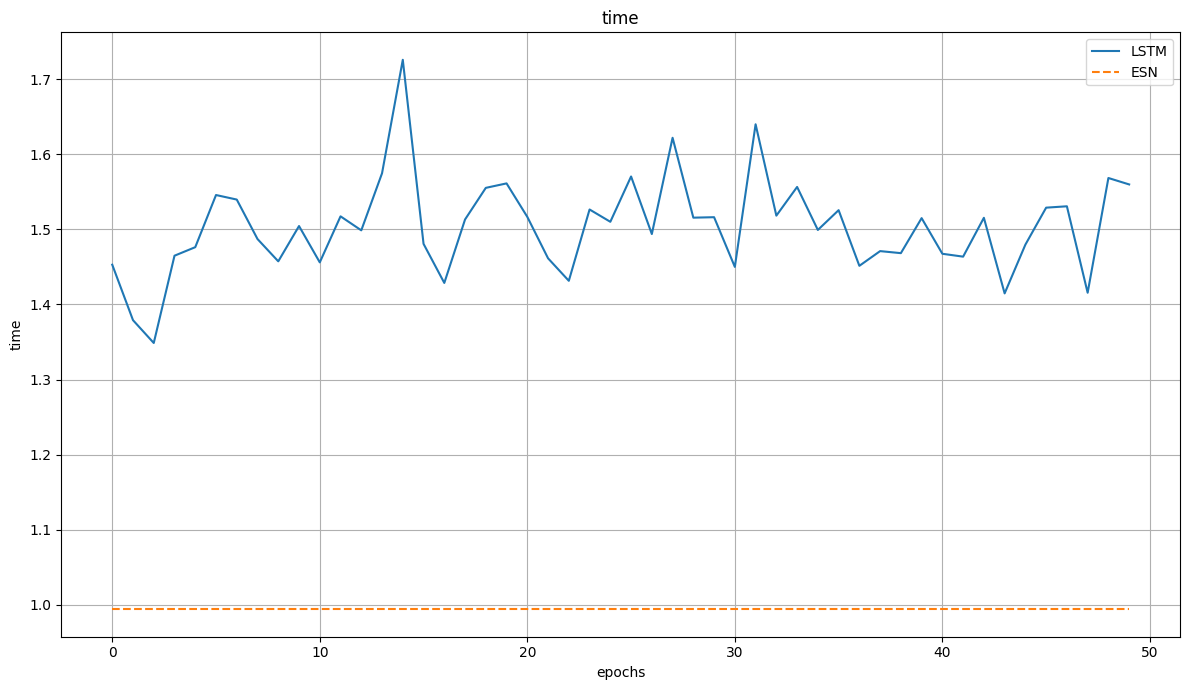

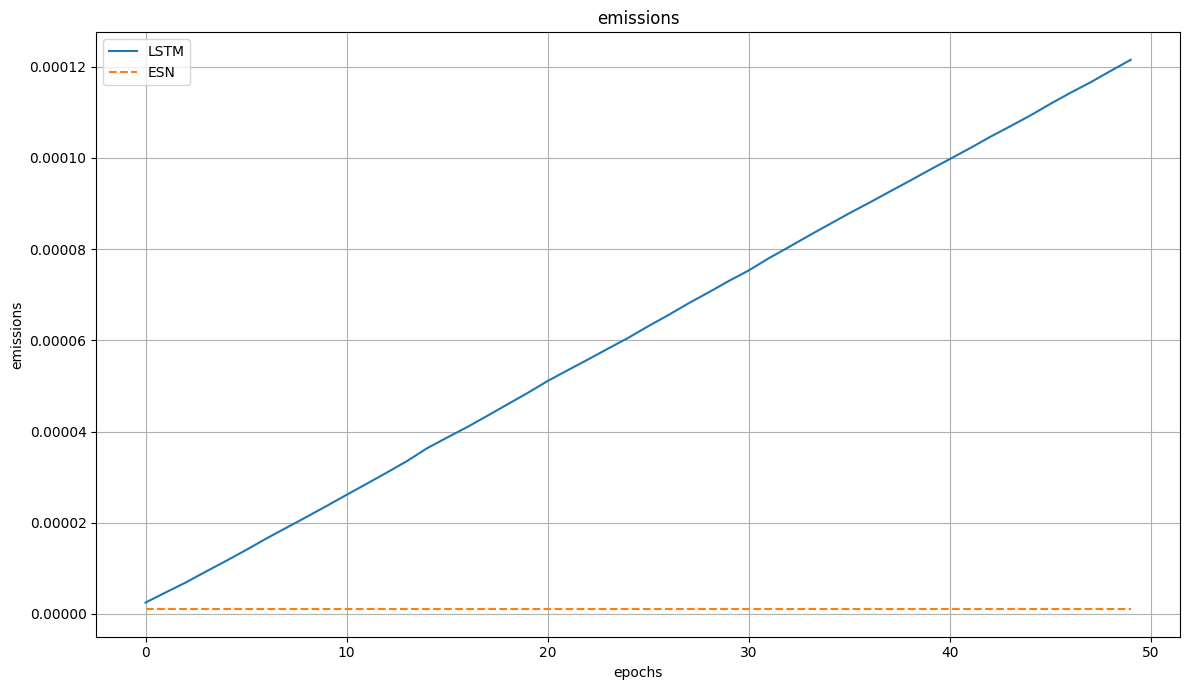

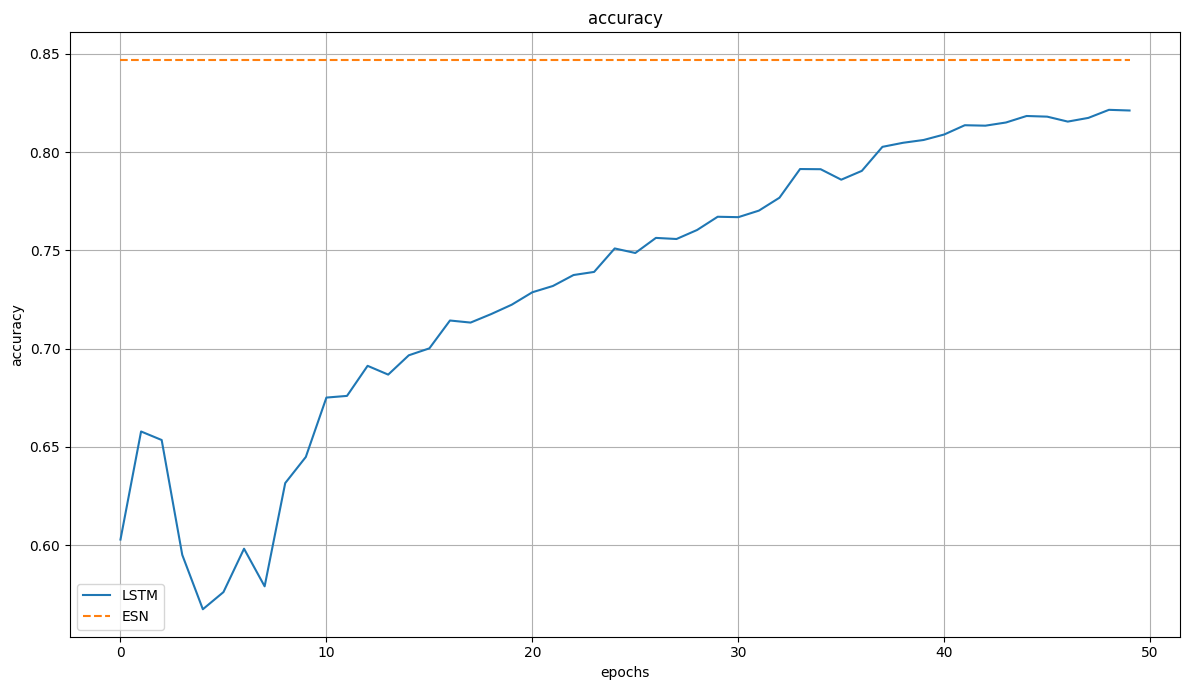

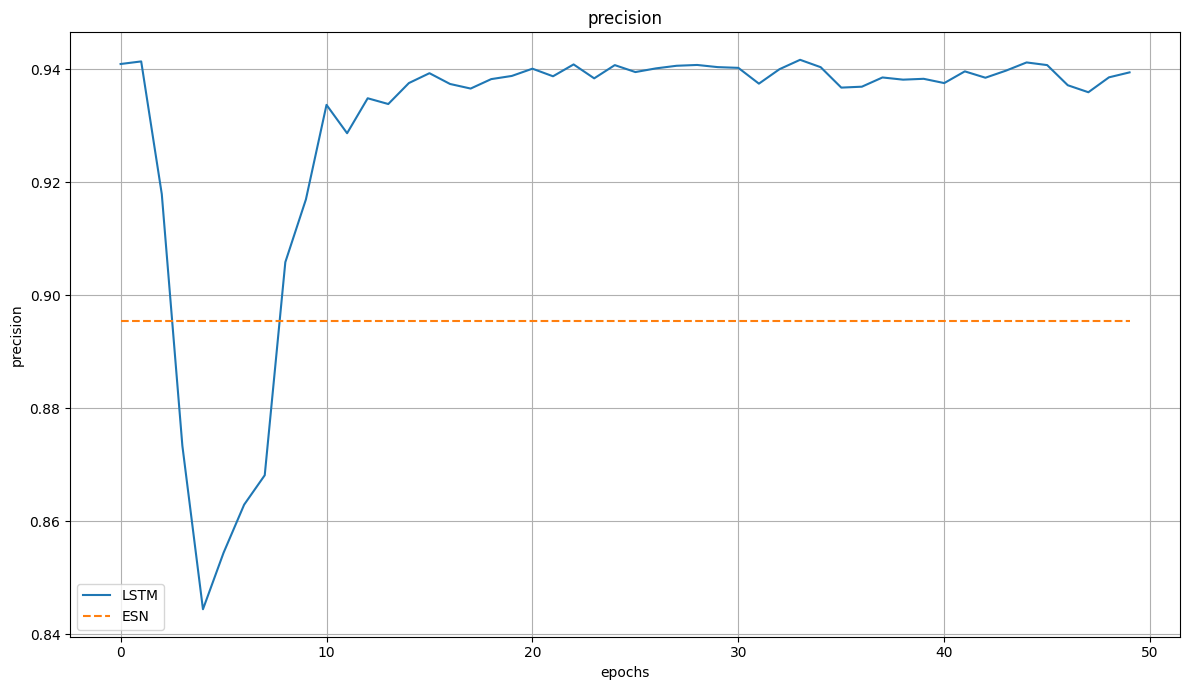

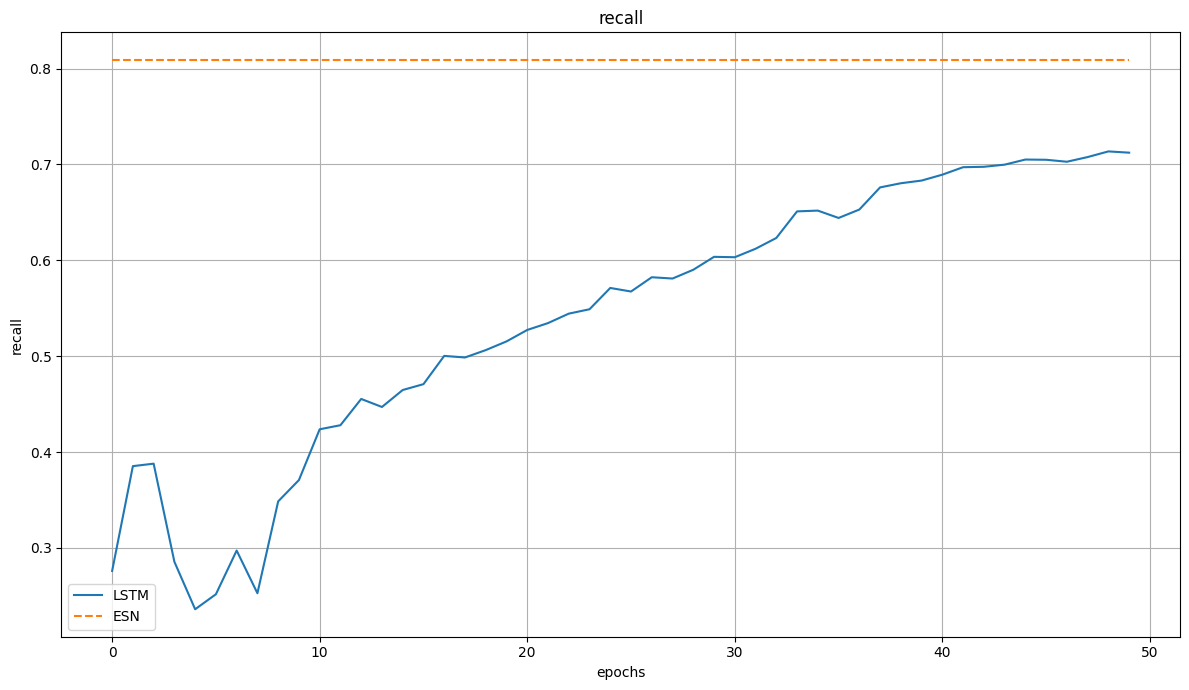

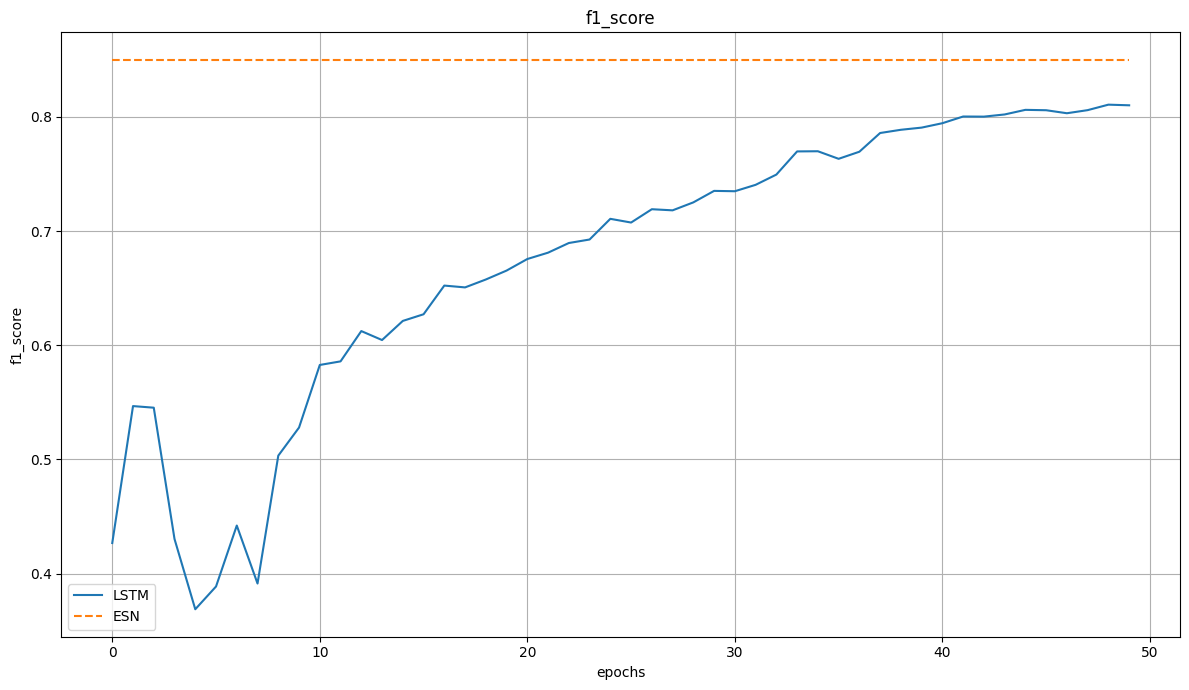

In [8]:
for k in esn_results.keys():
    plot(k)